## Raspagem de dados do site TOTALCORNER e montando o DataFrame

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import cloudscraper

#Raspagem de dados to site TOTALCORNER
def get_corner_stats(team_id:str,is_home:bool='all'):
    scraper = cloudscraper.create_scraper()
    n_pages = 2
    first_half_corners_for = []
    second_half_corners_for = []
    match_corners_for = []
    first_half_corners_against = []
    second_half_corners_against = []
    match_corners_against = []
    total_match_corners = []
    total_first_half_corners = []
    total_second_half_corners =[]
    home_or_away = []
    corners_balance =[]
    against = []
    team_name = ''

    for page in range(1,n_pages + 1):
        time.sleep(1)

        html = scraper.get(f'https://www.totalcorner.com/team/view/{team_id}/page:{page}').content

        soup = BeautifulSoup(html, 'html.parser')
        if not soup.find("meta", {"name":"description"}):
            print('CAPTCHA')
            break
        if team_name == '':
            team_name = soup.find("meta", {"name":"description"})["content"]
            team_name = team_name.split(",")[0].replace('Team: ','')
        



        table_rows = soup.findAll("tr")
        for rows in table_rows:
            #Ignorando jogos que ainda não aconteceram
            if rows.find("span", class_="span_half_corner hide"):
                continue
            match = rows.find("td", class_="match_home")
            #Pegando nome do time que joga em casa
            if match != None:
                home_team = match.find('a').text
            #Ignorando possiveis linhas que não são referente a partidas
            else:
                continue
            match = rows.find("td", class_="match_away")
            #Pegando nome do time que joga fora de casa
            if match != None:
                away_team = match.find('a').text
            #Pegando dados sobre escanteios
            half_corners = rows.find("span", class_="span_half_corner").text
            match_corners = rows.find("span", class_="span_match_corner").text
            home_half_corners = half_corners.replace('(','').replace(')','').split('-')[0]
            away_half_corners = half_corners.replace('(','').replace(')','').split('-')[1]
            home_match_corners = match_corners.split(' ')[0]
            away_match_corners = match_corners.split(' ')[-1]
            home_second_half_corners = int(home_match_corners) - int(home_half_corners)
            away_second_half_corners = int(away_match_corners) - int(away_half_corners)
            #Organizando dados para o dataframe
            if home_team == team_name:
                against.append(away_team)            
                balance = int(home_match_corners) - int(away_match_corners)
                first_half_corners_for.append(int(home_half_corners))
                second_half_corners_for.append(int(home_second_half_corners))
                match_corners_for.append(int(home_match_corners))
                first_half_corners_against.append(int(away_half_corners))
                second_half_corners_against.append(int(away_second_half_corners))
                match_corners_against.append(int(away_match_corners))
                total_match_corners.append(int(home_match_corners) + int(away_match_corners))
                total_first_half_corners.append(int(home_half_corners) + int(away_half_corners))
                total_second_half_corners.append(int(home_second_half_corners) + int(away_second_half_corners))
                home_or_away.append('Home')
                corners_balance.append(balance)

            else:
                against.append(home_team)  
                balance = int(away_match_corners) - int(home_match_corners)
                first_half_corners_for.append(int(away_half_corners))
                second_half_corners_for.append(int(away_second_half_corners))
                match_corners_for.append(int(away_match_corners))
                first_half_corners_against.append(int(home_half_corners))
                second_half_corners_against.append(int(home_second_half_corners))
                match_corners_against.append(int(home_match_corners))
                total_match_corners.append(int(home_match_corners) + int(away_match_corners))
                total_first_half_corners.append(int(home_half_corners) + int(away_half_corners))
                total_second_half_corners.append(int(home_second_half_corners) + int(away_second_half_corners))
                home_or_away.append('Away')
                corners_balance.append(balance)
    #Criando DataFrame
    df = pd.DataFrame(list(zip(
            first_half_corners_for,
            second_half_corners_for,
            match_corners_for,
            first_half_corners_against,
            second_half_corners_against,
            match_corners_against,
            total_match_corners,
            total_first_half_corners,
            total_second_half_corners,
            home_or_away,
            corners_balance,
            against
        )),
        columns=[
            'first_half_corners_for',
            'second_half_corners_for',
            'match_corners_for',
            'first_half_corners_against',
            'second_half_corners_against',
            'match_corners_against',
            'total_match_corners',
            'total_first_half_corners',
            'total_second_half_corners',
            'home_or_away',
            'corners_balance',
            'against'

        ])
    if is_home == 'all':
        return (team_name, df)
    if is_home:
        return (team_name, df[(df.home_or_away == "Home")])
    else:
        return (team_name, df[(df.home_or_away == "Away")])


### Criando relátorio com fairlines de escanteios para as principais partidas de hoje

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import datetime

games_percentage = 0.70
lower_part = (1-games_percentage)/2
higher_part = games_percentage + lower_part

def get_fairlines(corner_lines_range,home_corner_series,away_corner_series,over_or_under,ft_or_1h):
    fairlines = {}
    if over_or_under.lower() == 'over':
        for corner in corner_lines_range:
                #Percentual de partidas com MAIS de X escanteios
                home = (home_corner_series > corner).mean()
                away = (away_corner_series > corner).mean()
                if home == 0 or away == 0:
                    home = 9999
                else:
                    home = round(1/home,2)
                    away = round(1/away,2)
                fairlines[f'{ft_or_1h}_over_{corner}.5'] = max(home,away)
    else:
        for corner in corner_lines_range:
                #Percentual de partidas com MENOS de X escanteios
                home = (home_corner_series < corner).mean()
                away = (away_corner_series < corner).mean()
                if home == 0 or away == 0:
                    home = 9999
                else:
                    home = round(1/home,2)
                    away = round(1/away,2)
                fairlines[f'{ft_or_1h}_under_{corner - 1 }.5'] = max(home,away)
    return fairlines



def generate_report():
    desired_leagues = ["France Ligue 1",'Portugal Primeira Liga','Netherlands Eredivisie','	Spain Primera Liga','Spain Segunda','Italy Serie B',
                       'England Championship','England Premier League','Germany Bundesliga I','Italy Serie A','Colombia Primera A','Uruguay Apertura',
                        'Chile Primera Division','Argentina Liga Profesional','USA MLS','Paraguay Division Profesional',
                       'Venezuela Primera Division','Mexico Liga MX','Japan J-League','Germany Bundesliga II','UEFA Champions League',
                       'Copa do Brasil','Copa Libertadores','Copa Sudamericana','UEFA Europa League']
    result = []
    html = requests.get('https://www.totalcorner.com/match/schedule').content
    soup = BeautifulSoup(html, 'html.parser')
    table_rows = soup.findAll("tr")
    #Lendo as linhas da tabela
    for rows in table_rows:
        game = {}
        minutes = rows.find('span', class_="match_status_minutes")
        #ignorando linhas que não tem a coluna de tempo da partida
        if not minutes:
            continue
        #ignorando partidas que já começaram
        if minutes.text == "":
            links = rows.findAll('a', href=True)
            league = links[0].text
            #Filtrando ligas
            if league not in desired_leagues:
                continue
            #Pegando ID dos times
            home_team_id = links[1]['href'].split('/')[-1]
            away_team_id = links[2]['href'].split('/')[-1]
            #Pegando os dados de escanteios dos times.
            home_team_name, df_home = get_corner_stats(home_team_id,True)
            time.sleep(1)
            away_team_name, df_away = get_corner_stats(away_team_id,False)
            #Encerra o loop caso o site peça CAPTCHA
            if not (home_team_name and away_team_name):
                break
            else:
                game['Name'] = f'{home_team_name} X {away_team_name}'
                #Percentual de partidas com saldo de escanteios positivos e negativos
                home_balance = round((df_home.corners_balance > 0).mean()*100)
                negative_home_balance = round((df_home.corners_balance < 0).mean()*100)
                away_balance = round((df_away.corners_balance > 0).mean()*100)
                negative_away_balance = round((df_away.corners_balance < 0).mean()*100)
                #Definindo linhas de over e under escanteios para analise
                first_half_over_range = range(1,6)
                first_half_under_range = range(7,4,-1)
                full_time_over_range = range(6,13)
                full_time_under_range = range(12,8,-1)

                print(f'{home_team_name} X {away_team_name}')
                game.update(get_fairlines(first_half_over_range,df_home.total_first_half_corners,df_away.total_first_half_corners,'over','1H'))
                game.update(get_fairlines(first_half_under_range,df_home.total_first_half_corners,df_away.total_first_half_corners,'under','1H'))
                game.update(get_fairlines(full_time_over_range,df_home.total_match_corners,df_away.total_match_corners,'over','FT'))
                game.update(get_fairlines(full_time_under_range,df_home.total_match_corners,df_away.total_match_corners,'under','FT'))
                result.append(game)

                balance_dif = home_balance - away_balance 
                if abs(balance_dif) >= 40:
                    if(home_balance > away_balance):
                        fair = 1/((home_balance + negative_away_balance)/200)
                        game.update({'most_corners':home_team_name,'most_corners_fairline':fair})
                    else:
                        fair = 1/((negative_home_balance + away_balance)/200)
                        game.update({'most_corners':home_team_name,'most_corners_fairline':fair})
                else:
                    game.update({'most_corners':'-','most_corners_fairline':'-'})
    result_df = pd.DataFrame.from_records(result)
    try:
        with pd.ExcelWriter(f'fairlines{datetime.date.today()}.xlsx',mode='a',engine="openpyxl",if_sheet_exists='replace') as writer:
            result_df.to_excel(writer, index=False,sheet_name='Fairlines')
    except:
        with pd.ExcelWriter(f'fairlines{datetime.date.today()}.xlsx',mode='w',engine="openpyxl") as writer:
            result_df.to_excel(writer, index=False,sheet_name='Fairlines')
      



generate_report()

Athletico Paranaense X CRB
Ituano X Sao Paulo
Atletico Huila X Independiente Medellin
Nottm Forest X Brighton
West Ham X Liverpool
Chelsea X Brentford
Man City X Arsenal
Sheff Utd X West Brom
Once Caldas X Boyaca Chico
Deportes Tolima X Jaguares de Cordoba
Santos X Botafogo SP
Sport Recife X Coritiba
Brasil de Pelotas X Atletico Mineiro
Aguia de Maraba X Fortaleza FC


### Pegando odds da Betano

In [3]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By


def get_odds(search_term):
    try:
        print('Getting odds for', search_term)
        url = "https://br.betano.com/" 
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')
        options.add_argument('--window-size=1920x1080')
        driver = webdriver.Chrome(options=options)
        driver.get(url) 
        
        # Garantindo que a pagina foi carregada
        time.sleep(2)
        #Fechando popup inicial
        close_modal = driver.find_element(By.CLASS_NAME,'sb-modal__close__btn')
        close_modal.click()
        #clicando no icone de busca
        search = driver.find_element(By.CLASS_NAME,'sb-header__header__actions__search-icon')
        search.click()
        time.sleep(1)
        #Digitando confronto no input de busca
        driver.find_element(By.CLASS_NAME,'uk-input').send_keys(search_term)
        time.sleep(3)
        if len(driver.find_elements(By.CLASS_NAME,'search-modal__empty-state')) != 0:
            driver.find_element(By.CLASS_NAME,'uk-input').send_keys(Keys.CONTROL + "a")
            driver.find_element(By.CLASS_NAME,'uk-input').send_keys(Keys.DELETE)
            driver.find_element(By.CLASS_NAME,'uk-input').send_keys(search_term.split('X')[0])
            time.sleep(3)
        #Caso não seja encontrado retorna um objeto com o nome do confronto
        if len(driver.find_elements(By.CLASS_NAME,'search-modal__empty-state')) != 0:
            print('Jogo Não encontrado')
            return {'Name':search_term}
        #Caso encontrado clica no primeiro resultado
        else:
            if len(driver.find_elements(By.CLASS_NAME,'search-result')) == 0:
                time.sleep(4)
            driver.find_element(By.CLASS_NAME,'search-result').click()
            time.sleep(5)
            #Procura categoria escanteio e clica nela
            categories = driver.find_elements(By.CLASS_NAME,'GTM-tab-name')
            for category in categories:
                if 'escanteios' in category.get_attribute("innerHTML").lower():
                    category.click()
                    time.sleep(2)
            #passa o html estatico para o beautiful soup
            html = driver.page_source
            soup = BeautifulSoup(html, "html.parser")
            #Pega todos os mercados de escanteios
            corner_markets = soup.find_all('div',class_='markets__market__header__title')
            market_titles = ['Name']
            market_odds = [search_term]
            #Filtra apenas os mercados de interesse (FT Mais/Menos e HT Mais/Menos)
            #Armazena as odds e o nome do mercado em uma lista cada.
            for market in corner_markets:
                if 'Escanteios' in market.text.split()[0] and 'Mais/Menos' in market.text.split()[1]:
                    parent_tag = market.parent.parent
                    titles = parent_tag.find_all('span',class_='selections__selection__title')
                    odds = parent_tag.find_all('span',class_='selections__selection__odd')
                    market_titles = market_titles + [title.text.replace('Mais de','FT_over_').replace('Menos de','FT_under_') for title in titles]
                    market_odds = market_odds + [odd.text.split()[0] for odd in odds]
                if 'Mais/Menos' in market.text.split()[0] and '1' in market.text.split()[1]:
                    parent_tag = market.parent.parent
                    titles = parent_tag.find_all('span',class_='selections__selection__title')
                    odds = parent_tag.find_all('span',class_='selections__selection__odd')
                    market_titles = market_titles + [title.text.replace('Mais de','1H_over_').replace('Menos de','1H_under_') for title in titles]
                    market_odds = market_odds + [odd.text.split()[0] for odd in odds]
            print('Odds Found !')        
            return dict(zip(market_titles,market_odds))
    except Exception as e:
        print('Error getting odds',str(e))
        return {'Name':search_term}
        

        


### Preenchendo planilha com ODDS betano

In [4]:
#Lê a planilha com as fairlines criadas
df_fairlines = pd.read_excel(f'fairlines{datetime.date.today()}.xlsx')
odds_result = []
#Para cada jogo busca as odds na betano
for game in list(df_fairlines.Name):
    odds_result.append(get_odds(game))
#Cria um dataframe com as odds
odds_df = pd.DataFrame.from_records(odds_result)
display(odds_df)



Getting odds for Athletico Paranaense X CRB
Odds Found !
Getting odds for Ituano X Sao Paulo
Odds Found !
Getting odds for Atletico Huila X Independiente Medellin
Odds Found !
Getting odds for Nottm Forest X Brighton
Odds Found !
Getting odds for West Ham X Liverpool
Odds Found !
Getting odds for Chelsea X Brentford
Odds Found !
Getting odds for Man City X Arsenal
Odds Found !
Getting odds for Sheff Utd X West Brom
Jogo Não encontrado
Getting odds for Once Caldas X Boyaca Chico
Odds Found !
Getting odds for Deportes Tolima X Jaguares de Cordoba
Odds Found !
Getting odds for Santos X Botafogo SP
Odds Found !
Getting odds for Sport Recife X Coritiba
Odds Found !
Getting odds for Brasil de Pelotas X Atletico Mineiro
Jogo Não encontrado
Getting odds for Aguia de Maraba X Fortaleza FC
Odds Found !


,Name,FT_over_11.5,FT_under_11.5,1H_over_5.5,1H_under_5.5,FT_over_10.5,FT_under_10.5,FT_over_12.5,FT_under_12.5,1H_over_4.5,...,1H_over_1.5,1H_under_1.5,1H_over_7.5,1H_under_7.5,1H_over_8.5,1H_under_8.5,1H_over_9.5,1H_under_9.5,FT_over_18.5,FT_under_18.5
0,Athletico Paranaense X CRB,1.95,1.78,1.98,1.78,1.60,2.25,2.50,1.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ituano X Sao Paulo,2.37,1.55,2.25,1.60,1.87,1.88,3.10,1.34,1.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Atletico Huila X Independiente Medellin,3.70,1.25,3.05,1.35,2.72,1.42,NaN,NaN,2.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nottm Forest X Brighton,2.92,1.38,2.57,1.47,2.20,1.62,3.95,1.22,1.80,...,1.04,9.50,6.10,1.10,9.00,1.04,11.50,1.01,NaN,NaN
4,West Ham X Liverpool,3.05,1.34,2.67,1.44,2.30,1.57,4.20,1.20,1.85,...,1.04,9.25,6.40,1.10,9.25,1.04,11.75,1.01,NaN,NaN
5,Chelsea X Brentford,2.57,1.47,2.40,1.53,2.00,1.75,3.40,1.29,1.70,...,1.03,10.00,5.50,1.13,8.00,1.06,11.00,1.02,14.00,1.006
6,Man City X Arsenal,3.55,1.27,2.92,1.37,2.60,1.45,4.90,1.16,1.98,...,1.05,8.50,7.10,1.08,10.00,1.03,12.50,1.01,NaN,NaN
7,Sheff Utd X West Brom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Once Caldas X Boyaca Chico,NaN,NaN,3.85,1.24,3.75,1.24,NaN,NaN,2.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Deportes Tolima X Jaguares de Cordoba,3.75,1.25,3.05,1.35,2.75,1.42,NaN,NaN,2.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Limpando e organizando os dataframes de ODDS e Fairlines para compará-los e encontrar oportunidades

In [5]:
df_fairlines = pd.read_excel(f'fairlines{datetime.date.today()}.xlsx')
odds_df = pd.DataFrame.from_records(odds_result)
#Removendo colunas de odds que não tenham fairlines calculadas
for column in odds_df.columns:
    if column not in df_fairlines.columns:
        odds_df.drop(column,inplace=True, axis='columns')
#Removendo colunas com mercados especiais
df_fairlines.drop(['most_corners','most_corners_fairline'],axis='columns',inplace=True)
#Reordenando as colunas
cols = list(odds_df.columns)
cols.pop(0)
sorted_cols = sorted(cols)
sorted_cols.insert(0,'Name')
odds_df = odds_df[sorted_cols]
df_fairlines = df_fairlines[sorted_cols]
#Removendo linhas que não foram encontradas odds na betano
df_fairlines = df_fairlines[df_fairlines.Name.isin(odds_df.Name)]
df_fairlines.reset_index(inplace=True,drop=True)
#Criando novo dataframe com a diferença entre fairline e odds
diff = pd.DataFrame()
df_fairlines.iloc[:,1:] = df_fairlines.iloc[:,1:].astype(float)
odds_df.iloc[:,1:] = odds_df.iloc[:,1:].astype(float)
diff['Name']= df_fairlines.Name
diff = pd.concat([diff, df_fairlines.iloc[:,1:] - odds_df.iloc[:,1:]],axis=1)
display(diff)



,Name,1H_over_1.5,1H_over_2.5,1H_over_3.5,1H_over_4.5,1H_over_5.5,1H_under_4.5,1H_under_5.5,1H_under_6.5,FT_over_10.5,FT_over_11.5,FT_over_12.5,FT_over_6.5,FT_over_7.5,FT_over_8.5,FT_over_9.5,FT_under_10.5,FT_under_11.5,FT_under_8.5,FT_under_9.5
0,Athletico Paranaense X CRB,NaN,NaN,NaN,NaN,1.88,NaN,0.03,NaN,1.78,3.45,11.0,NaN,NaN,NaN,NaN,0.17,-0.07,NaN,NaN
1,Ituano X Sao Paulo,NaN,NaN,NaN,0.46,1.13,-0.03,-0.07,0.14,0.21,2.13,5.9,NaN,NaN,0.19,0.06,0.72,0.07,-0.05,0.47
2,Atletico Huila X Independiente Medellin,NaN,0.11,-0.04,0.29,0.95,0.12,0.01,0.01,2.28,2.3,NaN,NaN,0.22,0.52,0.95,0.05,0.15,-0.05,-0.07
3,Nottm Forest X Brighton,0.1,0.25,0.42,0.98,2.43,0.12,-0.21,-0.08,1.02,4.33,3.3,0.26,0.42,0.35,0.33,-0.15,0.01,0.55,0.05
4,West Ham X Liverpool,0.01,0.25,0.76,1.26,2.0,-0.37,-0.09,0.14,0.81,0.45,0.4,0.19,0.26,0.86,1.0,0.07,0.1,-0.25,-0.29
5,Chelsea X Brentford,0.01,0.06,0.05,0.3,0.49,1.04,0.62,0.13,0.6,0.23,0.93,0.2,0.2,0.26,0.02,0.25,0.15,0.5,0.55
6,Man City X Arsenal,-0.01,-0.06,0.63,1.59,3.33,0.09,-0.04,0.16,0.52,1.45,9.1,0.07,0.14,0.4,0.5,0.11,0.13,0.0,0.0
7,Sheff Utd X West Brom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Once Caldas X Boyaca Chico,NaN,0.73,0.9,0.38,0.15,0.13,0.23,0.17,0.92,NaN,NaN,0.24,0.27,0.31,0.41,0.23,NaN,0.0,0.23
9,Deportes Tolima X Jaguares de Cordoba,NaN,0.1,0.03,0.65,3.7,0.51,0.58,0.29,6.25,5.25,NaN,NaN,0.43,0.8,1.79,0.29,0.07,0.75,0.72


In [6]:
def get_odds(row):
    return odds_df.loc[odds_df["Name"] == row['Jogo']][row['Market']].values[0]
#Criando dataFrame onde fairline - odd(betano) < -0.14,
#  ou seja betano está pagando mais do que consideramos justo
oportunities = diff[diff.loc[:,'1H_over_1.5':] < -0.14]
#Removendo valores ausentes
oportunities.dropna(axis=0,how='all',inplace=True)
oportunities.dropna(axis=1,how='all',inplace=True)
#Pegando novamente o nome dos confrontos
oportunities = oportunities.merge(odds_df['Name'],left_index=True,right_index=True,how='inner')
oportunities.set_index("Name",inplace=True)
#Transformando as oportunidades em uma lista de entradas
oportunities = oportunities.stack().reset_index().set_axis(['Jogo', 'Market', 'Margem'], axis=1, inplace=False)
#Buscando as odds das oportunidades
oportunities['Odd'] = oportunities.apply(get_odds, axis=1 )
display(oportunities)





,Jogo,Market,Margem,Odd
0,Nottm Forest X Brighton,1H_under_5.5,-0.21,1.47
1,Nottm Forest X Brighton,FT_under_10.5,-0.15,1.62
2,West Ham X Liverpool,1H_under_4.5,-0.37,1.90
3,West Ham X Liverpool,FT_under_8.5,-0.25,2.55
4,West Ham X Liverpool,FT_under_9.5,-0.29,1.93


#### Updating Excel

In [7]:
with pd.ExcelWriter(f'fairlines{datetime.date.today()}.xlsx',mode='a',engine="openpyxl",if_sheet_exists='replace') as writer:
    odds_df.to_excel(writer, sheet_name='betano_odds', index=False)
    diff.to_excel(writer,sheet_name="Fair - Betano", index=False)
    oportunities.to_excel(writer, sheet_name="Oportunidades",index=False)

### Relátorio teste confronto entre duas equipes

Arsenal Jogando em casa


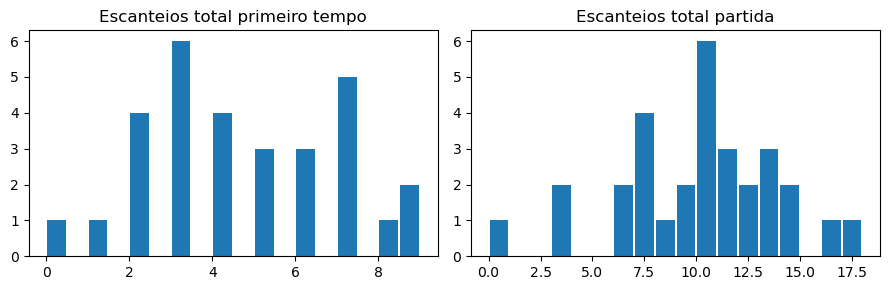

 PRIMEIRO TEMPO: 
1H 85% das partidas - de 7.5 escanteios
1H 85% das partidas + de  1.5 escanteios
1H partidas com menos de 6.5  73 % Fairline: 1.36
1H partidas com menos de 5.5  63 % Fairline: 1.58
1H partidas com menos de 4.5  53 % Fairline: 1.88
1H partidas com mais de 1.5  93 % Fairline: 1.07
1H partidas com mais de 2.5  80 % Fairline: 1.25
1H partidas com mais de 3.5  60 % Fairline: 1.67
JOGO COMPLETO: 
FT 85% das partidas - de  13.5 escanteios
FT 85% das partidas + de  5.5 escanteios
FT partidas com menos de 10.5  60 % Fairline: 1.67
FT partidas com menos de 9.5  40 % Fairline: 2.5
FT partidas com menos de 8.5  33 % Fairline: 3.0
FT partidas com mais de 6.5  83 % Fairline: 1.2
FT partidas com mais de 7.5  70 % Fairline: 1.43
FT partidas com mais de 8.5  67 % Fairline: 1.5
Partidas com saldo de escanteios positivo:  80 %
Partidas com saldo de escanteios negativo:  13 %
Partidas escanteios empatados:  7 %
Média escanteios por partida:  10
desvio padrão:  4


,first_half_corners_for,second_half_corners_for,match_corners_for,first_half_corners_against,second_half_corners_against,match_corners_against,total_match_corners,total_first_half_corners,total_second_half_corners,home_or_away,corners_balance,against
0,4,3,7,1,1,2,9,5,4,Home,5,Southampton
3,1,3,4,0,3,3,7,1,6,Home,1,Leeds
4,3,2,5,1,3,4,9,4,5,Home,1,Crystal Palace
5,1,2,3,2,5,7,10,3,7,Home,-4,Sporting
7,9,8,17,0,1,1,18,9,9,Home,16,Bournemouth
8,2,3,5,1,0,1,6,3,3,Home,4,Everton
11,1,0,1,2,0,2,3,3,0,Home,-1,Man City
12,3,4,7,3,1,4,11,6,5,Home,3,Brentford
15,6,6,12,1,3,4,16,7,9,Home,8,Man Utd
18,0,5,5,2,3,5,10,2,8,Home,0,Newcastle


Southampton Jogando fora de casa


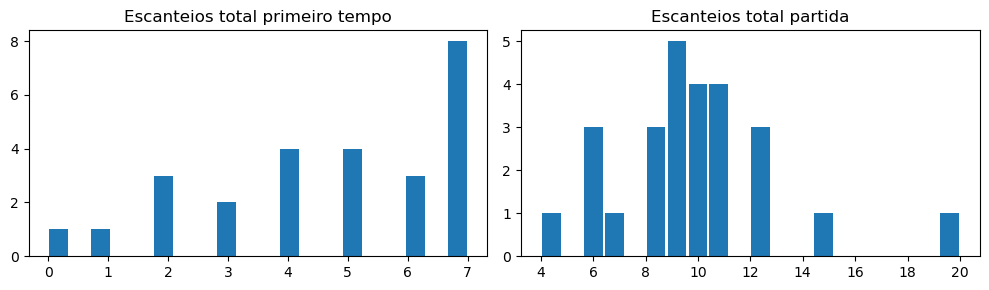

 PRIMEIRO TEMPO: 
1H 85% das partidas - de 7.5 escanteios
1H 85% das partidas + de  1.5 escanteios
1H partidas com menos de 6.5  69 % Fairline: 1.44
1H partidas com menos de 5.5  58 % Fairline: 1.73
1H partidas com menos de 4.5  42 % Fairline: 2.36
1H partidas com mais de 1.5  92 % Fairline: 1.08
1H partidas com mais de 2.5  81 % Fairline: 1.24
1H partidas com mais de 3.5  73 % Fairline: 1.37
JOGO COMPLETO: 
FT 85% das partidas - de  12.5 escanteios
FT 85% das partidas + de  5.5 escanteios
FT partidas com menos de 10.5  65 % Fairline: 1.53
FT partidas com menos de 9.5  50 % Fairline: 2.0
FT partidas com menos de 8.5  31 % Fairline: 3.25
FT partidas com mais de 6.5  85 % Fairline: 1.18
FT partidas com mais de 7.5  81 % Fairline: 1.24
FT partidas com mais de 8.5  69 % Fairline: 1.44
Partidas com saldo de escanteios positivo:  27 %
Partidas com saldo de escanteios negativo:  54 %
Partidas escanteios empatados:  19 %
Média escanteios por partida:  10
desvio padrão:  3


,first_half_corners_for,second_half_corners_for,match_corners_for,first_half_corners_against,second_half_corners_against,match_corners_against,total_match_corners,total_first_half_corners,total_second_half_corners,home_or_away,corners_balance,against
0,1,1,2,4,3,7,9,5,4,Away,-5,Arsenal
3,1,2,3,1,4,5,8,2,6,Away,-2,West Ham
6,4,4,8,3,4,7,15,7,8,Away,1,Man Utd
9,0,2,2,5,4,9,11,5,6,Away,-7,Leeds
10,0,2,2,1,7,8,10,1,9,Away,-6,Chelsea
12,2,2,4,4,0,4,8,6,2,Away,0,Brentford
13,0,1,1,4,1,5,6,4,2,Away,-4,Newcastle
17,2,2,4,2,4,6,10,4,6,Away,-2,Everton
19,0,1,1,4,4,8,9,4,5,Away,-7,Crystal Palace
21,2,2,4,1,3,4,8,3,5,Away,0,Fulham


In [8]:

team_id = 6
team2_id = 20 

home_name, df_home = get_corner_stats(team_id,True)
away_name, df_away = get_corner_stats(team2_id,False)


print(home_name, "Jogando em casa")
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.hist(df_home.total_first_half_corners.tolist(), int(df_home.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total primeiro tempo")
plt.plot()
plt.subplot(1, 2, 2)
plt.hist(df_home.total_match_corners.tolist(), int(df_home.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total partida")
plt.plot()
plt.tight_layout()
plt.show()

print(" PRIMEIRO TEMPO: ")
print('1H 85% das partidas - de', df_home.total_first_half_corners.quantile(0.85,interpolation="higher")+0.5, "escanteios")
print('1H 85% das partidas + de ', df_home.total_first_half_corners.quantile(0.15, interpolation="lower")-0.5, "escanteios")
print('1H partidas com menos de 6.5 ', round((df_home.total_first_half_corners < 7).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 7).mean(),2))
print('1H partidas com menos de 5.5 ', round((df_home.total_first_half_corners < 6).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 6).mean(),2))
print('1H partidas com menos de 4.5 ', round((df_home.total_first_half_corners < 5).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 5).mean(),2))
print('1H partidas com mais de 1.5 ', round((df_home.total_first_half_corners > 1).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 1).mean(),2))
print('1H partidas com mais de 2.5 ', round((df_home.total_first_half_corners > 2).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 2).mean(),2))
print('1H partidas com mais de 3.5 ', round((df_home.total_first_half_corners > 3).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 3).mean(),2))
print("JOGO COMPLETO: ")
print('FT 85% das partidas - de ', df_home.total_match_corners.quantile(0.85,interpolation="higher")+0.5, "escanteios")
print('FT 85% das partidas + de ', df_home.total_match_corners.quantile(0.15,interpolation="lower")-0.5, "escanteios")
print('FT partidas com menos de 10.5 ', round((df_home.total_match_corners < 11).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 11).mean(),2))
print('FT partidas com menos de 9.5 ', round((df_home.total_match_corners < 10).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 10).mean(),2))
print('FT partidas com menos de 8.5 ', round((df_home.total_match_corners < 9).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 9).mean(),2))
print('FT partidas com mais de 6.5 ', round((df_home.total_match_corners > 6).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 6).mean(),2))
print('FT partidas com mais de 7.5 ', round((df_home.total_match_corners > 7).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 7).mean(),2))
print('FT partidas com mais de 8.5 ', round((df_home.total_match_corners > 8).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 8).mean(),2))
print('Partidas com saldo de escanteios positivo: ', round((df_home.corners_balance > 0).mean()*100), "%")
print('Partidas com saldo de escanteios negativo: ', round((df_home.corners_balance < 0).mean()*100), "%")
print('Partidas escanteios empatados: ', round((df_home.corners_balance == 0).mean()*100), "%")
print('Média escanteios por partida: ', round((df_home.total_match_corners).mean()))
print('desvio padrão: ', round((df_home.total_match_corners).std()))
display(df_home)


print(away_name,"Jogando fora de casa")
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(df_away.total_first_half_corners.tolist(), int(df_away.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total primeiro tempo")
plt.plot()
plt.subplot(1, 2, 2)
plt.hist(df_away.total_match_corners.tolist(), int(df_away.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total partida")
plt.plot()
plt.tight_layout()
plt.show()
print(" PRIMEIRO TEMPO: ")
print('1H 85% das partidas - de', df_away.total_first_half_corners.quantile(0.85,interpolation="higher")+.5, "escanteios")
print('1H 85% das partidas + de ', df_away.total_first_half_corners.quantile(0.15, interpolation="lower")-.5, "escanteios")
print('1H partidas com menos de 6.5 ', round((df_away.total_first_half_corners < 7).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 7).mean(),2))
print('1H partidas com menos de 5.5 ', round((df_away.total_first_half_corners < 6).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 6).mean(),2))
print('1H partidas com menos de 4.5 ', round((df_away.total_first_half_corners < 5).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 5).mean(),2))
print('1H partidas com mais de 1.5 ', round((df_away.total_first_half_corners > 1).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 1).mean(),2))
print('1H partidas com mais de 2.5 ', round((df_away.total_first_half_corners > 2).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 2).mean(),2))
print('1H partidas com mais de 3.5 ', round((df_away.total_first_half_corners > 3).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 3).mean(),2))
print("JOGO COMPLETO: ")
print('FT 85% das partidas - de ', df_away.total_match_corners.quantile(0.85,interpolation="higher")+.5, "escanteios")
print('FT 85% das partidas + de ', df_away.total_match_corners.quantile(0.15,interpolation="lower")-.5, "escanteios")
print('FT partidas com menos de 10.5 ', round((df_away.total_match_corners < 11).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 11).mean(),2))
print('FT partidas com menos de 9.5 ', round((df_away.total_match_corners < 10).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 10).mean(),2))
print('FT partidas com menos de 8.5 ', round((df_away.total_match_corners < 9).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 9).mean(),2))
print('FT partidas com mais de 6.5 ', round((df_away.total_match_corners > 6).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 6).mean(),2))
print('FT partidas com mais de 7.5 ', round((df_away.total_match_corners > 7).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 7).mean(),2))
print('FT partidas com mais de 8.5 ', round((df_away.total_match_corners > 8).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 8).mean(),2))
print('Partidas com saldo de escanteios positivo: ', round((df_away.corners_balance > 0).mean()*100), "%")
print('Partidas com saldo de escanteios negativo: ', round((df_away.corners_balance < 0).mean()*100), "%")
print('Partidas escanteios empatados: ', round((df_away.corners_balance == 0).mean()*100), "%")
print('Média escanteios por partida: ', round((df_away.total_match_corners).mean()))
print('desvio padrão: ', round((df_away.total_match_corners).std()))
display(df_away)
